In [17]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import shap
##performs a global interpretation of  XGBoost model using SHAP (SHapley Additive exPlanations) values.
#SHAP is a powerful method to explain the output of any machine learning model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV#a powerful technique used for hyperparameter tuning in machine learning.
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from xgboost import XGBClassifier#: This library implements gradient boosting algorithms, specifically for tree-based models


In [3]:

# Step 2: Load Dataset
df = pd.read_csv('/content/drive/MyDrive/telco_churn.csv')

In [4]:

# Step 3: Clean & Preprocessing
#drop unneccesary cloumns
df.drop(columns=['customerID', 'Unnamed: 0'], errors='ignore', inplace=True)
df.replace(' ', np.nan, inplace=True)#handle missing values

# Convert 'TotalCharges' to numeric and fill missing values
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# Fill missing categorical values with mode
for col in df.select_dtypes(include=['object', 'bool']).columns:
    if df[col].isnull().any():
        df[col].fillna(df[col].mode()[0], inplace=True)

# Encode target column
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# One-hot encode categorical features
df_encoded = pd.get_dummies(df, drop_first=True)


/tmp/ipython-input-1319177617.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)
/tmp/ipython-input-1319177617.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, i

In [12]:
# Step 4: Split Data
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

# Drop rows where 'Churn' (y) is NaN to ensure y does not contain missing values
nan_indices = y[y.isnull()].index
X = X.drop(nan_indices)
y = y.drop(nan_indices)
# This ensures that your training data is clean and consistent.
#train 80% data,test 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Step 5: Train Model with Tuning
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')#specifies the evaluation metric to be used during training,
params = {
    'n_estimators': [100],#The number of boosting rounds or trees to build
    'max_depth': [3],#The maximum depth of a tree
    'learning_rate': [0.1]#The step size shrinkage used to prevent overfitting
}
grid = GridSearchCV(model, params, cv=3, scoring='f1')#This means a 3-fold cross-validation will be performed
grid.fit(X_train, y_train)
best_model = grid.best_estimator_

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [09:57:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [09:57:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [09:57:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [09:57:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [14]:
# Step 6: Evaluate Model
y_pred = best_model.predict(X_test)#These y_pred are the model's predicted churn outcomes for the test customers.

print("Classification Report:\n", classification_report(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1]))
print("F1 Score:", f1_score(y_test, y_pred))
#calculates the F1-score, which is the harmonic mean of precision and recall.

Classification Report:
               precision    recall  f1-score   support

         0.0       0.78      0.89      0.83       288
         1.0       0.61      0.40      0.49       121

    accuracy                           0.75       409
   macro avg       0.70      0.65      0.66       409
weighted avg       0.73      0.75      0.73       409

AUC Score: 0.8246097337006428
F1 Score: 0.48756218905472637


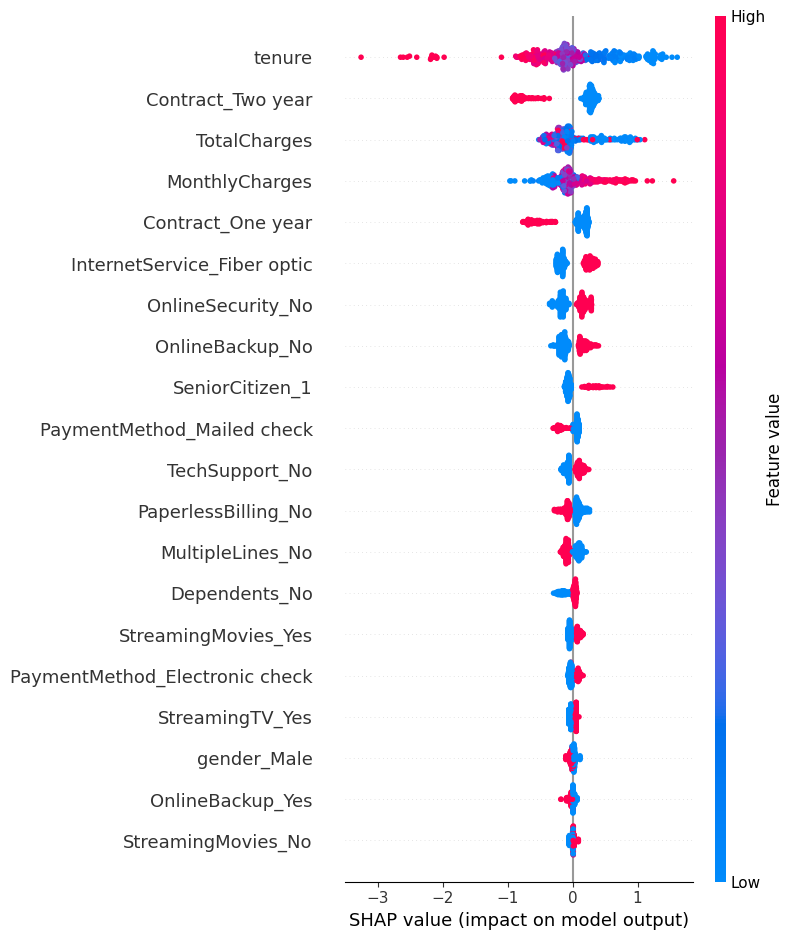

In [15]:
# Step 7: SHAP Global Interpretation
#convert data to float
X_train_float = X_train.astype(float)
X_test_float = X_test.astype(float)
#Each SHAP value represents the contribution of a feature to the prediction of a single instance, compared to the average prediction.
explainer = shap.Explainer(best_model, X_train_float)
shap_values = explainer(X_test_float)
shap.summary_plot(shap_values, X_test_float)

Total Customers Selected for Analysis: 5

Customer 1 Analysis(Original Index:0---
Prediction:Churn

Customer 1 Prediction: Churn


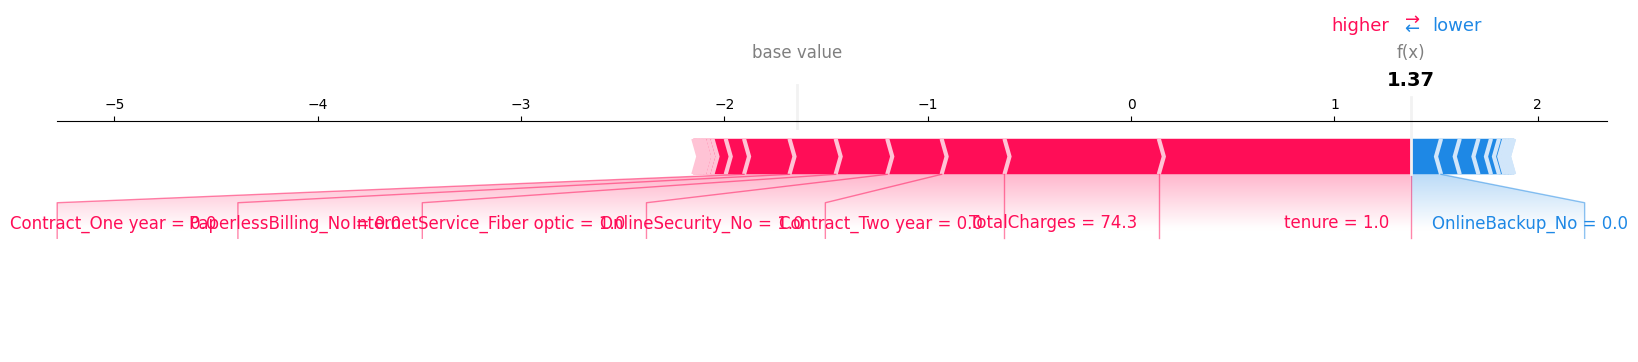


Customer 2 Analysis(Original Index:6---
Prediction:Churn

Customer 7 Prediction: Churn


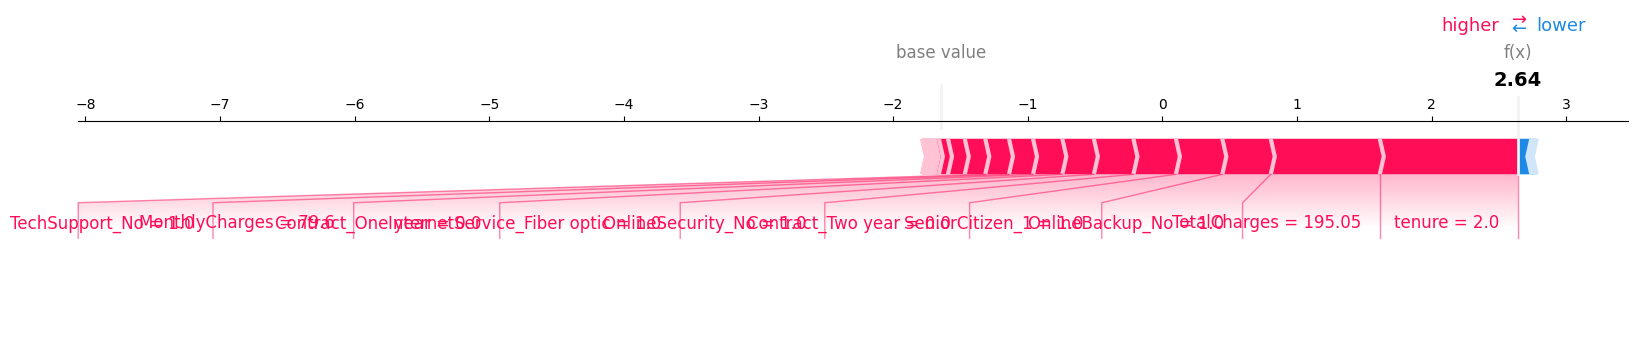


Customer 3 Analysis(Original Index:0---
Prediction:Churn

Customer 1 Prediction: Churn


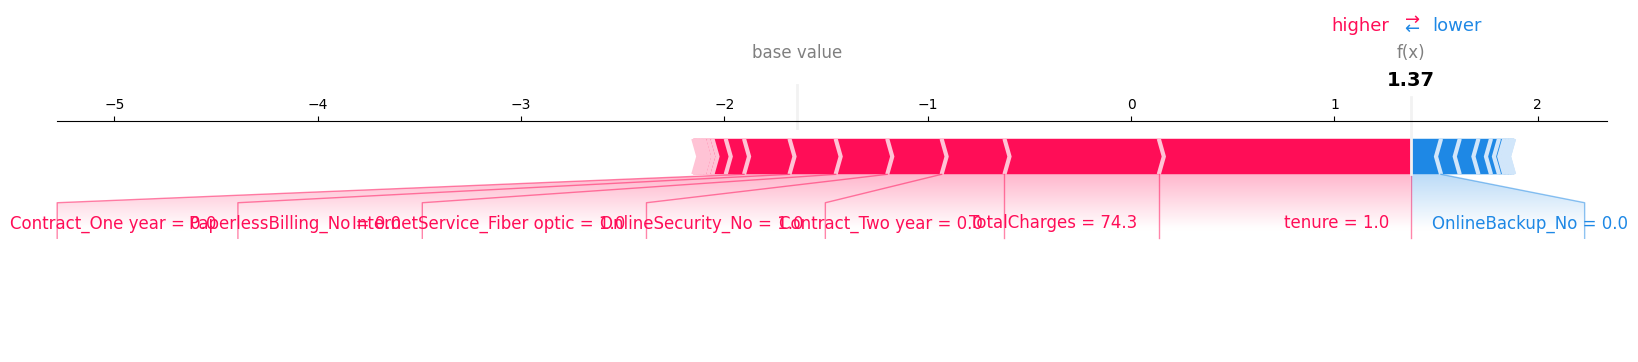


Customer 4 Analysis(Original Index:6---
Prediction:Churn

Customer 7 Prediction: Churn


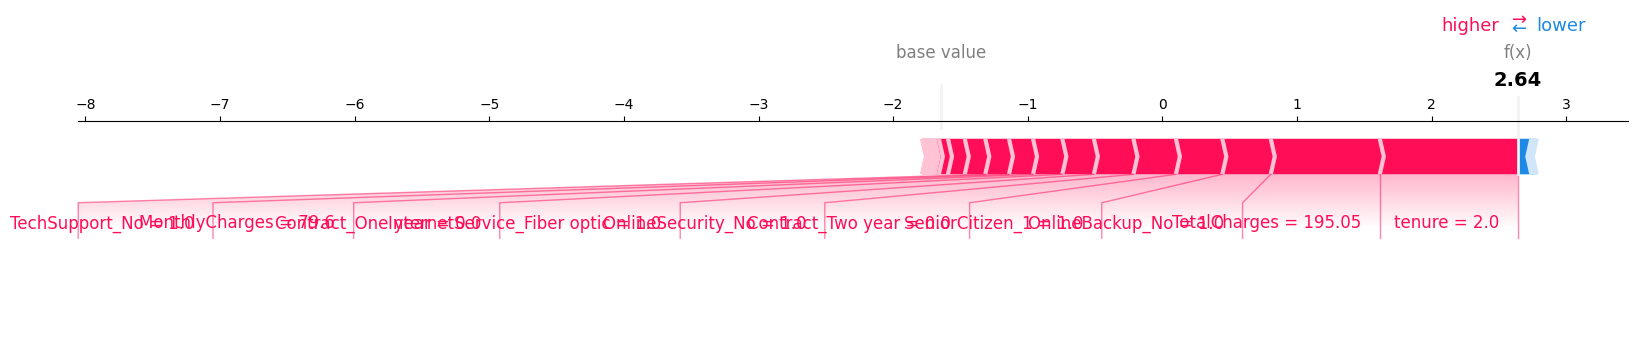


Customer 5 Analysis(Original Index:7---
Prediction:Churn

Customer 8 Prediction: Churn


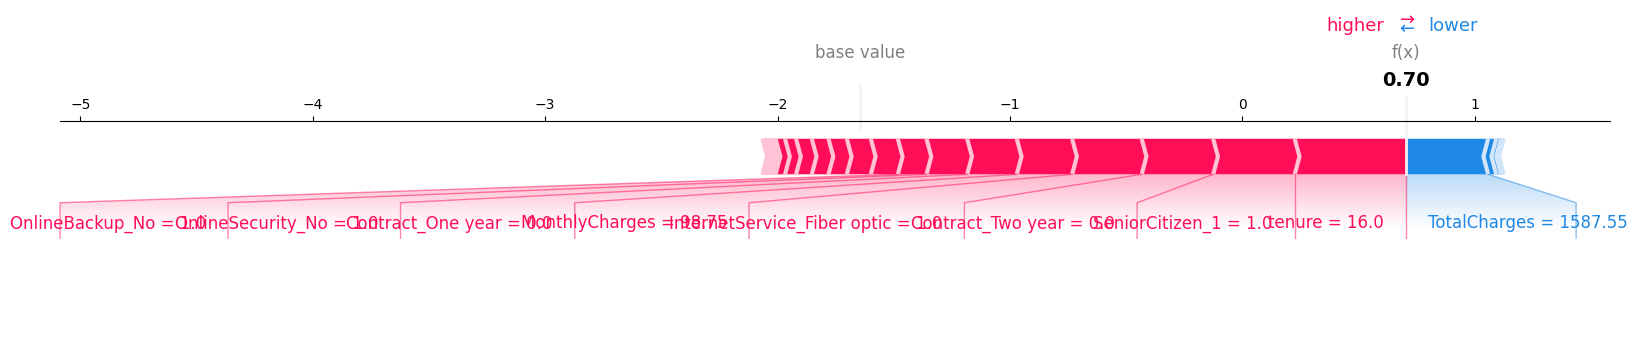

In [20]:
# Step 8: SHAP Local Interpretation for 5 Customers
SAMPLE_SIZE=20

sample_customers_large = X_test_float.sample(SAMPLE_SIZE, random_state=42)
sample_shap_values_large = explainer(sample_customers_large)
prediction_large = best_model.predict(sample_customers_large)
churn_indices = [i for i,pred in enumerate(prediction_large == 1) if pred==1]#churn=1
no_churn_indices = [i for i,pred in enumerate(prediction_large == 0) if pred==0]#no churn
num_churn=2
num_no_churn=3
final_indices = churn_indices[:num_churn] + no_churn_indices[:num_no_churn]
final_indices=final_indices[:5]
print(f"Total Customers Selected for Analysis: {len(final_indices)}")
count=0
for i in final_indices:
    count+=1
    shap_values_to_plot = sample_shap_values_large[i]
    prediction=prediction_large[i]
    print(f"\nCustomer {count} Analysis(Original Index:{i}---")
    print(f"Prediction:{'Churn' if prediction==1 else'No Churn'}")
    print(f"\nCustomer {i+1} Prediction: {'Churn' if prediction == 1 else 'No Churn'}")
    shap.plots.force(shap_values_to_plot, matplotlib=True)

In [18]:
# Predict churn on test set
y_pred = best_model.predict(X_test)

# Combine predictions with original test data
results = X_test.copy()
results['Actual_Churn'] = y_test.values
results['Predicted_Churn'] = y_pred

# Map binary to labels
results['Predicted_Label'] = results['Predicted_Churn'].map({1: 'Churn', 0: 'No Churn'})
results['Actual_Label'] = results['Actual_Churn'].map({1: 'Churn', 0: 'No Churn'})

# Display first few rows
print(results[['Actual_Label', 'Predicted_Label']].head(10))

# Count predictions
print("\nPrediction Summary:")
print(results['Predicted_Label'].value_counts())


     Actual_Label Predicted_Label
4316     No Churn        No Churn
4000     No Churn        No Churn
4068        Churn        No Churn
4970        Churn        No Churn
3529     No Churn        No Churn
5005     No Churn        No Churn
3414        Churn        No Churn
3982     No Churn        No Churn
3416     No Churn        No Churn
4472     No Churn        No Churn

Prediction Summary:
Predicted_Label
No Churn    329
Churn        80
Name: count, dtype: int64
